In [ ]:
import sys

!{sys.executable} -m pip install -r reqs.txt

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import median, mean, mode, stdev
import scipy.stats
from math import sqrt

import jpype
import jpype.imports
from jpype import startJVM, shutdownJVM, java, addClassPath, JClass

### Collect data

#### Intialise JVM from Python

In [59]:
startJVM(convertStrings=False, classpath=["../out/production/SortComplexity"])

In [60]:
# java.lang.System.out.println("Hello world !")
try:
    Benchmarks = JClass("stats.Benchmarks")
except Exception as e:
    print(f"Exception: {e}")

18747


#### Functions to collect sort times

Get all times for every `interval` size starting from the given `start_size`, going for `x` times and running the method `n` times for each size.

In [61]:
def run_uniform_sizes(interval, x, n, start_size=0):
    df = pd.DataFrame(columns=["size", "merge_min", "merge_max", "merge_mean", "merge_median", "selection_min", "selection_max", "selection_mean", "selection_median"])
    
    for i in range(x+1):
        size = start_size + interval*i
        merge_times = []
        selection_times = []
        
        for j in range(n):
            merge_times.append(Benchmarks.testMergeSort(int(size)))
            selection_times.append(Benchmarks.testSelectionSort(int(size)))
                      
        df.loc[len(df.index)] = [size, min(merge_times), max(merge_times), mean(merge_times), median(merge_times), min(selection_times), max(selection_times), mean(selection_times), median(selection_times)]
        
    return df

Find the crossover point using the `run_uniform_sizes` function. 

The function zooms into the range where the two sort algorithms cross over and does the same thing until the cross-over range is of length 1.

In [62]:
def find_crossover_point(interval, x, n, start_size=0, measure="mean"):
    while True:
        
        times = run_uniform_sizes(interval, x, n, start_size=start_size)
        
        # display(times)
        
        merge_faster = times[["size", "merge_" + measure, "selection_" + measure]].rename(columns={"merge_" + measure: "faster"}).copy()
        merge_faster["faster"] = times["merge_" + measure] < times["selection_" + measure]
        # faster["selection"] = ~faster["merge"]
        
        if merge_faster.loc[0, "faster"]:
            return merge_faster.loc[0, "size"]
        
        # display(merge_faster)
        
        col = merge_faster.faster.to_numpy()
        if not (col[0] == col).all():
            last_slower_index = merge_faster[~merge_faster["faster"]].index[-1]
            if last_slower_index+1 >= merge_faster.shape[0]:
                continue
            
            last_slower_size = merge_faster.loc[last_slower_index, "size"]
            first_faster_size = merge_faster.loc[last_slower_index+1, "size"]
            
            break
    
    # display(last_slower_index)
    # display(last_slower_size)
    
    if first_faster_size - last_slower_size == 1:
        return first_faster_size
    
    return find_crossover_point(interval / (first_faster_size - last_slower_size), last_slower_index, n, start_size=last_slower_size)

#### Visually find the cross-over point using median and mean sort times.

In [63]:
uniform_sizes = run_uniform_sizes(1, 200, 10000)

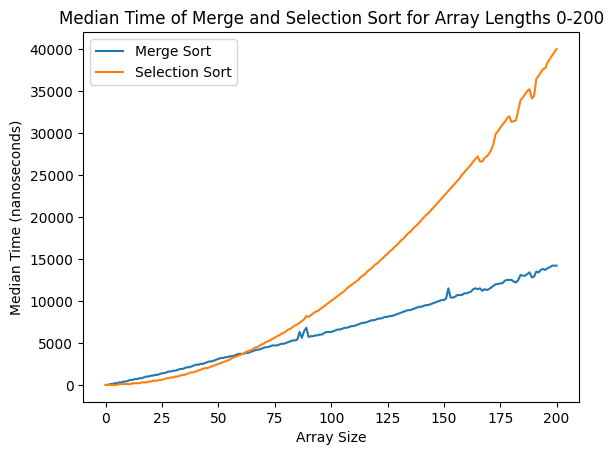

In [115]:
melted_df = pd.melt(uniform_sizes[["size", "merge_median", "selection_median"]].rename(columns={"merge_median": "Merge Sort", "selection_median": "Selection Sort"}), ["size"])
sns.lineplot(data=melted_df, x="size", y="value", hue="variable")
# sns.lineplot(data=uniform_sizes, x="size", y="selection_median")

# plt.legend(["merge sort",])
plt.legend(title="")
plt.title("Median Time of Merge and Selection Sort for Array Lengths 0-200")
plt.xlabel("Array Size")
plt.ylabel("Median Time (nanoseconds)")
plt.show()

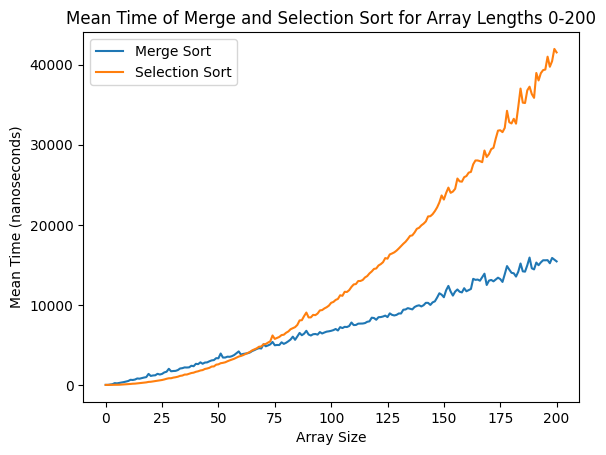

In [114]:
melted_df = pd.melt(uniform_sizes[["size", "merge_mean", "selection_mean"]].rename(columns={"merge_mean": "Merge Sort", "selection_mean": "Selection Sort"}), ["size"])
sns.lineplot(data=melted_df, x="size", y="value", hue="variable")
# sns.lineplot(data=uniform_sizes, x="size", y="selection_median")

# plt.legend(["merge sort",])
plt.legend(title="")
plt.title("Mean Time of Merge and Selection Sort for Array Lengths 0-200")
plt.xlabel("Array Size")
plt.ylabel("Mean Time (nanoseconds)")
plt.show()

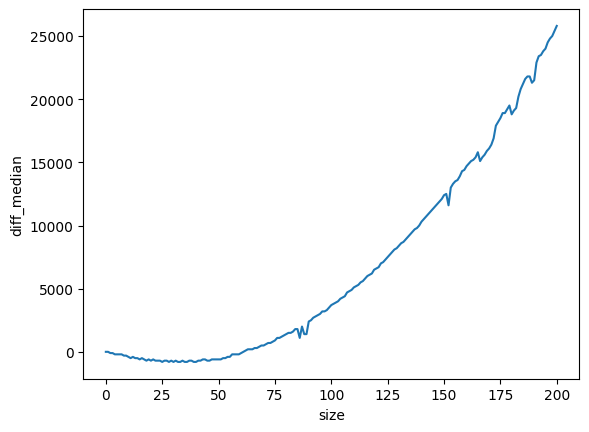

In [66]:
uniform_sizes["diff_mean"] = uniform_sizes.selection_mean - uniform_sizes.merge_mean
uniform_sizes["diff_median"] = uniform_sizes.selection_median - uniform_sizes.merge_median

# sns.lineplot(data=uniform_sizes, x="size", y="diff_mean")
sns.lineplot(data=uniform_sizes, x="size", y="diff_median")
plt.show()

#### Sample sort times

In [67]:
SAMPLE_SIZE = 30

In [68]:
median_sizes = []

for i in range(SAMPLE_SIZE):
    print(f"Iteration {i+1}", end='\r')
    median_sizes.append(find_crossover_point(1, 25, 10000, start_size=50, measure="median"))

print()

print(median_sizes)

Iteration 30
[65.0, 62.0, 68.0, 75.0, 67.0, 72.0, 70.0, 73.0, 69.0, 69.0, 64.0, 63.0, 62.0, 62.0, 70.0, 74.0, 64.0, 62.0, 70.0, 62.0, 62.0, 62.0, 62.0, 62.0, 62.0, 71.0, 62.0, 62.0, 62.0, 71.0]


In [69]:
print(median(median_sizes))
print(mean(median_sizes))
print(mode(median_sizes))

64.0
66.03333333333333
62.0


Look at sample distribution

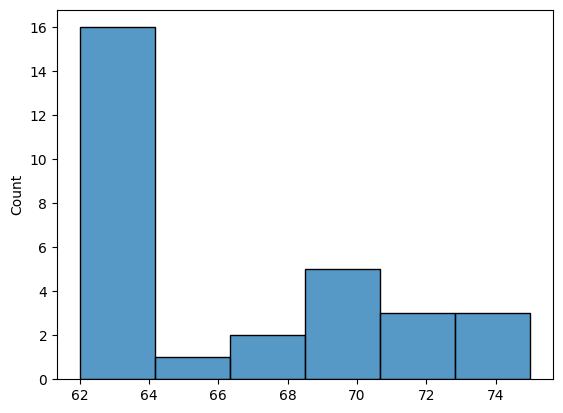

In [70]:
sns.histplot(median_sizes)
plt.show()

In [71]:
mean_sizes = []

for i in range(SAMPLE_SIZE):
    print(f"Iteration {i+1}", end='\r')
    mean_sizes.append(find_crossover_point(1, 25, 10000, start_size=50, measure="mean"))

print()

print(mean_sizes)

Iteration 30
[72.0, 64.0, 69.0, 63.0, 71.0, 66.0, 69.0, 69.0, 62.0, 72.0, 67.0, 65.0, 68.0, 71.0, 70.0, 67.0, 66.0, 67.0, 65.0, 66.0, 66.0, 75.0, 69.0, 68.0, 63.0, 66.0, 66.0, 63.0, 71.0, 67.0]


In [72]:
print(median(mean_sizes))
print(mean(mean_sizes))

67.0
67.43333333333334


Look at sample distribution

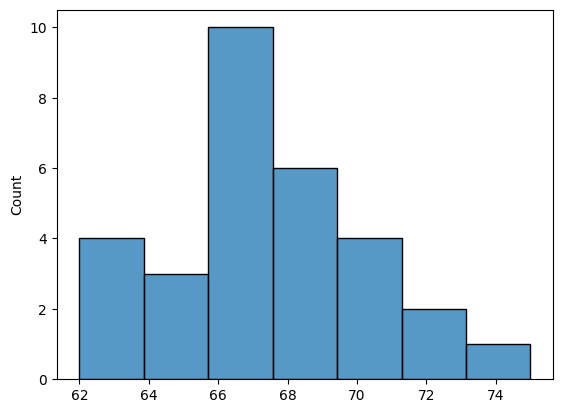

In [73]:
sns.histplot(mean_sizes)
plt.show()

### Calculate confidence interval

Using mean sizes because it is normally distributed

In [90]:
def confidence_interval(sample, alpha):    
    sample_size = len(sample)
    
    sample_mean = mean(mean_sizes)
    sample_stdev = stdev(mean_sizes)

    degrees_freedom = sample_size - 1

    t_value = scipy.stats.t.ppf(q=1-alpha, df=degrees_freedom)

    stderr = sample_stdev / sqrt(sample_size)

    margin_error = stderr * t_value

    upper = sample_mean + margin_error
    lower = sample_mean - margin_error
    
    return lower, upper

In [119]:
alpha = 0.01
lower, upper = confidence_interval(mean_sizes, alpha)

print(f"{(1-alpha) * 100}% confidence interval: {lower}, {upper}")
print(mean(mean_sizes))

99.0% confidence interval: 66.03818789591479, 68.82847877075189
67.43333333333334


#### Old Code

In [74]:
# def reset_file(filename, reset_text):
#     with open(filename, "w") as f:
#         f.write(reset_text)

In [75]:
# def run_exponential_sizes(start_size, base, x, n):
#     df = pd.DataFrame(columns=["size", "merge", "selection"])
#     for i in range(x+1):
#         size = start_size + base**i
#         merge_time = benchmark_class.averageMergeSortTime(n, size)
#         selection_time = benchmark_class.averageSelectionSortTime(n, size)
        
#         df.loc[len(df.index)] = [size, merge_time, selection_time]
        
#     return df
    
    # os.system(f"java -cp ../out/production/SortComplexity stats.Benchmarks {func} {n} {start_size + base ** i} ../analysis/{func}_times.csv")

In [76]:
# def find_crossover_point(base, x, n, start_size=0):
#     while True:
        
#         times = run_exponential_sizes(start_size, base, x, n)
#         # initial_merge = pd.read_csv("merge_times.csv")
        
#         # run_exponential_sizes(start_size, base, x, n, "selection")
#         # initial_selec = pd.read_csv("selection_times.csv")
        
#         # reset_file("merge_times.csv", "size,time\n")
#         # reset_file("selection_times.csv", "size,time\n")

#         # times = initial_merge.merge(initial_selec, on=["size"], suffixes=["_merge", "_selection"])
#         # times.rename(columns={"time_merge": "merge", "time_selection": "selection"}, inplace=True)
        
#         # display(times)
        
#         merge_faster = times[["size", "merge"]].rename(columns={"merge": "faster"}).copy()
#         merge_faster["faster"] = times["merge"] < times["selection"]
#         # faster["selection"] = ~faster["merge"]
        
#         if merge_faster.loc[0, "faster"]:
#             return merge_faster.loc[0, "size"]
        
#         # display(merge_faster)
        
#         col = merge_faster.faster.to_numpy()
#         if not (col[0] == col).all():
#             last_slower_index = merge_faster[~merge_faster["faster"]].index[-1]
#             if last_slower_index+1 >= merge_faster.shape[0]:
#                 continue
            
#             last_slower_size = merge_faster.loc[last_slower_index, "size"]
#             first_faster_size = merge_faster.loc[last_slower_index+1, "size"]
            
#             break
    
#     # display(last_slower_index)
#     # display(last_slower_size)
    
#     if first_faster_size - last_slower_size == 1:
#         return first_faster_size
    
#     return find_crossover_point(base, last_slower_index, n, start_size=last_slower_size)
    

In [77]:
# sample_size = 20
# sizes = []
# for i in range(sample_size):
#     sizes.append(find_crossover_point(2, 10, 1000))
    
# sum(sizes) / len(sizes)
# # run_exponential_sizes(32, 2, 5, 100, "merge")

In [78]:
# shutdownJVM()